In [1]:
# This is a clean version of the linear regression model

In [2]:
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
# writing for device-agnostic model
torch.__version__
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"using device {device}")

using device cpu


In [3]:
# Set data 
# given pars
weight = 0.7
bias = 0.3

# data
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1) # add extra dim
y = weight * X + bias # linear regression eq: Gradient + Intercept
print(X.shape, y.shape)

torch.Size([50, 1]) torch.Size([50, 1])


In [4]:
# create train/test split (basic method)
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]
len(X_train), len(y_train), len(X_test), len(y_test) # values as expected 80/20 split

(40, 40, 10, 10)

In [5]:
# plotting
def plot_predictions(train_data=X_train, train_labels=y_train, test_data = X_test, test_labels=y_test, predictions=None):
    """plots and comapres"""
    plt.figure(figsize=(5,3))
    # plot training
    plt.scatter(train_data,train_labels,c='b',s=4,label="Training data")
    # plot testing 
    plt.scatter(test_data,test_labels,c='g',s=4,label="Testing data")
    # are there are predictions:
    if (predictions is not None):
        # plot predictions
        assert len(test_data) == len(predictions)
        plt.scatter(test_data,predictions,c='r',s=4,label="Predictions data")
    plt.legend(prop={"size":12})

In [6]:
# Model
# create a linear regression model class (OOP)
class LinearRegressionModelV2(nn.Module):
    """ Use nn.Module
        nn.Mudule is the 'lego' bricks
        The model 
        1. will start from random parameters for : self.weights and self.bias
        2. update them to represent the test set data.
        
        The "learning" is done via an angorithm: 
        1. "Gradient Descent" (see requires_grad=True below)
        2. Back propagation
        Tracks the weights and bias graidents and updates them via grad. descent and back propagation
        
    """
    def __init__(self):
        super().__init__() # 
        # Initialize model parameters (anything, parameters, values, functions)
        # applies linear transformation to linear data. Equivalent to 'foward'
        self.linear_layer = nn.Linear(in_features=1, # X feature 1
                                      out_features=1 # Y-feature 1
                                      )
        
    # Forward method to define the computation in the model (Required by nn.Module)
    def forward(self, x:torch.Tensor)->torch.Tensor: 
        """ Overrides the base class method.
            x: input
            THis is a linear regression formula. (linear transformation)
            Each time the class is called the 'forward' is called 
        """
        return self.linear_layer(x)

In [11]:
# create a random seed
torch.manual_seed(42)
model_1 = LinearRegressionModelV2()
# Try to push model to cuda
print(next(model_1.parameters()).device)
try:
    # error out when is manually set to 'cuda'!
    model_1.to("cuda")
except RuntimeError:
    print("Failed to put the model on 'cuda'end")

cpu
Failed to put the model on 'cuda'end


In [15]:
# list named parameters `state_dict()`
print(model_1.state_dict())
# show parameters (they require grad (as in default train))
with torch.inference_mode():
    print(list(model_1.parameters()))

OrderedDict([('linear_layer.weight', tensor([[0.7645]])), ('linear_layer.bias', tensor([0.8300]))])
[Parameter containing:
tensor([[0.7645]], requires_grad=True), Parameter containing:
tensor([0.8300], requires_grad=True)]


In [13]:
''' setup a loss function '''
loss_fn = nn.L1Loss()
# wee need t ominimize the distances between red and 
# green dots and MAE will also go down

''' SEtup an optimizer'''
# usually, Loss function and optimizer comes together in a package
# see torch.optim()
# optimizer 'talks' to the loss function and checks whether 
# changes improves loss function output
# e.g., SGD - stocahstic gradiant descend or Adam
# Model improves by taking random numbers 
# Once a step that minimises the loss function is found, it 
# will move in that direction to minimises further
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr = 0.01)
# lr = learning rate VERY IMPORTANT hyperparameter (set)
# Controls how much a parameter is adjusted after each 
# 'good' guess of the SGR (adjust a little but or a lot)

In [20]:
# assure that optimizer also has the same 'seed' (reproducability)
torch.manual_seed(42)

# put data on the same device (device-agnostoc)
X_train = X_train.to(device=device)
y_train = y_train.to(device=device)
X_test = X_test.to(device=device)
y_test = X_test.to(device=device)

# an epoch is one loop through the data (epoch is hyperpar.)
epochs = 200

# Tracking experiment (values to track)
epoch_count = []
loss_vals = []
test_loss_vals = []

### TRAINING LOOP
# 0. loop through the data
for epoch in range(epochs):
    # Set model to training mode: (default training)
    # > All parameters that need grad. require grad now
    model_1.train()

    # 1. implement forward pass (forward function)
    # Learn partents on the train. data to eval. test data
    y_pred = model_1(X_train)

    # 2. Calculate the loss (MAE) in this case
    loss = loss_fn(y_pred, y_train) # (input,target)

    # 3. Optimizer 0-grad
    optimizer.zero_grad() #  Clear casch (for loss.bachwards() )

    # 4. Perform back propagation on the loss w/r model pars.
    # See youtube from 3Ble1Broun, 
    # Compute gradient of the loss func. with respect to model pars.
    # Find the minimum of the loss function (gradient extremum)
    loss.backward() # back propagation

    # 5. Step the optimizer (Perform gradient descend)
    # Optimizer cahnges accumulate through the loop 
    # (hast to be szeroed first in `zero_grad()`)
    # This is one of these 'frog leap' steps down the gradient curve
    optimizer.step() # gradient descend. always after loss.bachwards()


    # Testing Part Of the Loop.  
    # Evaluate model. turns off the gradient tracking;
    # dropout; BatchNorm...
    model_1.eval()
    with torch.inference_mode(): # turns off graient tracking, and others
        # No need to learn in testing...
        # 1. Forward pass in testing mode
        test_pred = model_1(X_test)
        
        # 2. Calcualte the loss
        test_loss = loss_fn(test_pred, y_test)

    
    # print the result
    if (epoch % 10 == 0):
        print(f"Epoch={epoch} | Loss: {loss} | test loss={test_loss}")
        # print(model_1.state_dict())

        # save progess for future use
        epoch_count.append(epoch)
        loss_vals.append(loss)
        test_loss_vals.append(test_loss)

Epoch=0 | Loss: 0.0012645035749301314 | test loss=0.021345829591155052
Epoch=10 | Loss: 0.0012645035749301314 | test loss=0.021345829591155052
Epoch=20 | Loss: 0.0012645035749301314 | test loss=0.021345829591155052
Epoch=30 | Loss: 0.0012645035749301314 | test loss=0.021345829591155052
Epoch=40 | Loss: 0.0012645035749301314 | test loss=0.021345829591155052
Epoch=50 | Loss: 0.0012645035749301314 | test loss=0.021345829591155052
Epoch=60 | Loss: 0.0012645035749301314 | test loss=0.021345829591155052
Epoch=70 | Loss: 0.0012645035749301314 | test loss=0.021345829591155052
Epoch=80 | Loss: 0.0012645035749301314 | test loss=0.021345829591155052
Epoch=90 | Loss: 0.0012645035749301314 | test loss=0.021345829591155052
Epoch=100 | Loss: 0.0012645035749301314 | test loss=0.021345829591155052
Epoch=110 | Loss: 0.0012645035749301314 | test loss=0.021345829591155052
Epoch=120 | Loss: 0.0012645035749301314 | test loss=0.021345829591155052
Epoch=130 | Loss: 0.0012645035749301314 | test loss=0.02134582

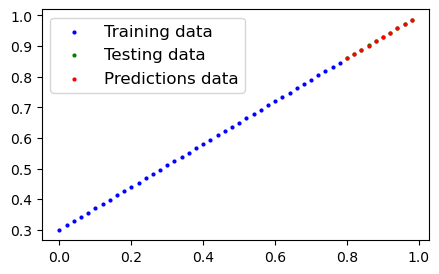

In [21]:
# predictions
with torch.inference_mode(): # with `with` -- turn off the gradient tracking! Faster for inferences
    y_preds_new = model_1(X_test)
    
# make sure the data is in CPU (as matplolib needs numpy)
y_preds_new = y_preds_new.to(device=device)
# plot new predictions after N manual iterations
plot_predictions(predictions=y_preds_new)

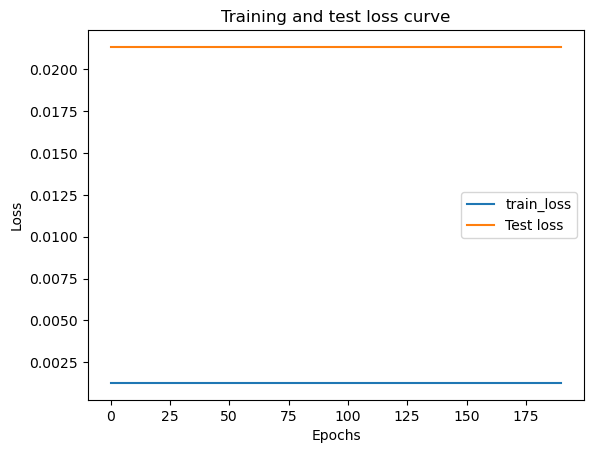

In [22]:
# evalaute model learning
plt.plot(epoch_count, torch.tensor(loss_vals).cpu().numpy(), label="train_loss")
plt.plot(epoch_count, torch.tensor(test_loss_vals).cpu().numpy(), label="Test loss")
plt.title("Training and test loss curve")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()